In [3]:
# Load relevant R packages
inLibraries = list('repr','spdep','raster','rgdal','rgeos')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Raster Operations

Consider the following scenario:

A client would like to purchase property for a weekend retreat. They have several core criteria: a) slope less than 6 degrees is most preferable, greater than 6 degrees but less than 20 degrees is tolerable, while slope greater than 20 degrees is not desirable; b) the further from the nearest road the better; c) forested and woodland areas are most desirable, open woodland is ok, while barren/scrub and prairie are the least desireable. To evalute these criteria, we have a 30m x 30m DEM (taneycomo/TaneyDEM1.tif), a 30m x 30m landuse/landcover raster (taneycomo/TaneyLULC.tif) and a 30m x 30m road dataset (taneycomo/Taroads.tif). 

Yes, that's right, we're using a raster road dataset. A vector road dataset (taneycomo/TaneyRoads.shp) could also be used and then converted to a raster dataset by applying the rasterize() function (raster library) as - rasterize(inRoads,rastertemplate,field=1,fun='count').  

In [6]:
# read DEM
inDEMname <- "datasets/taneycomo/TaneyDEM1.tif"
inDEM <- raster(inDEMname, values = TRUE)

In [7]:
# read lulc
inLULCname <- "datasets/taneycomo/TaneyLULC.tif"
inLULC <- raster(inLULCname, values = TRUE)

In [8]:
# read in roads
inROADSname <- "datasets/taneycomo/Taroads.tif"
inROADS <- raster(inROADSname, values = TRUE)

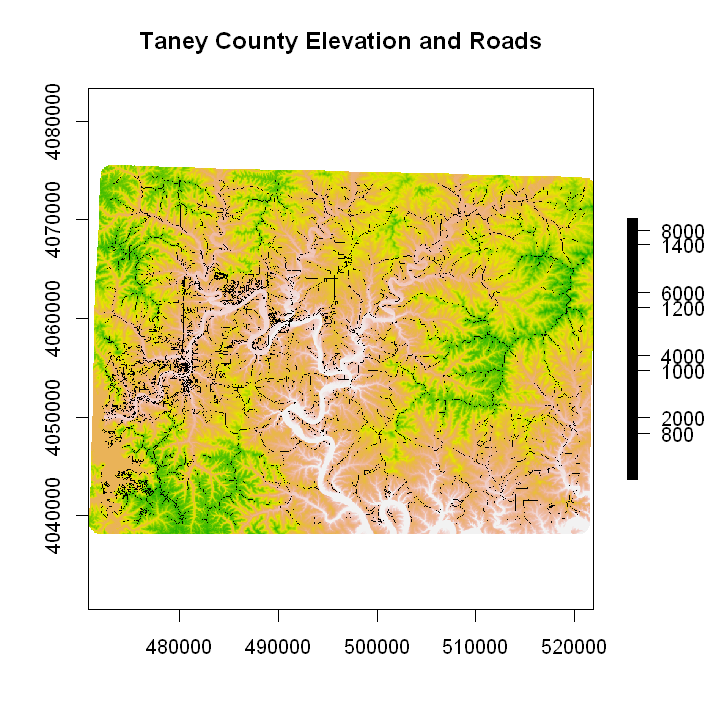

In [10]:
# display the rasters
plot(inDEM, topo.colors, main = "Taney County Elevation and Roads")
plot(inROADS, col = "black", add = TRUE)

## Slope

While not provided with a slope layer, one can be created rather easily using the terrain() function (raster library) as described in the lab.

In [20]:
# compute slope layer

SLOPE <- terrain(inDEM,
                     opt=c("slope"),
                     unit='degrees',
                     neighbors = 8)

## Aggregation

While 30m x 30m raster datasets are not really that large, the number of cells can make some raster operations rather unwieldly, especially when being conducted online. As such, it is often useful to aggregate the small cells to larger ones. Let's aggregate the datasets to 180m x 180m cells instead.  To do this, the aggregate() function (raster library) can be used. It's parameter 'fact' controls the number of cells (horizontally/vertically) that will aggregated. 'fun' is a function that determines how the values of the cells will be aggregated.

In [19]:
# aggregate datasets

aSLOPE <- aggregate(SLOPE, fact = 6, fun = max)

aLULC <- aggregate(inLULC, fact = 6, fun = max)

aROADS <- aggregate(inROADS, fact = 6, fun = mean)

## Distance to Roads

While not provided with distances to roads, the road data was provided. When the vector road data were converted to raster, the resulting raster road data contained values in cells whenever a road was present and <NA> values were associated with cells whenever a road was not present.  

Given this info, distance can be computed from every raster cell to the nearest cell containing a road. This task can be tackled using the distance() function (raster library). This function computes the distance from each NA cell in a rasterlayer to the nearest cell with a value (i.e. having a road). 

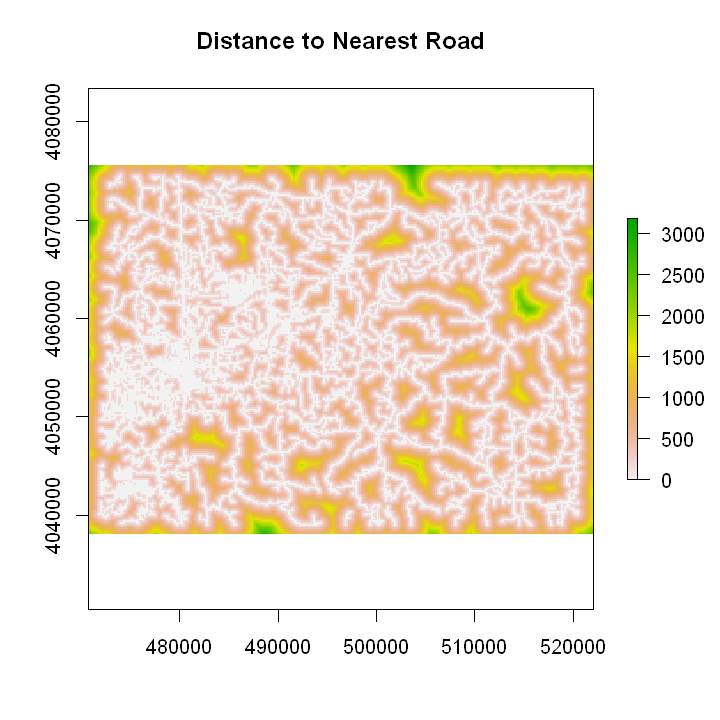

In [22]:
# compute the distance to roads
dROADS <- distance(aROADS)

# display distance raster
plot(dROADS, topo.colors, main = "Distance to Nearest Road")

## Aligning Raster Datasets

Now, for us to do any meaningful comparisons of the data, we need to ensure that a raster cell in one layer (i.e. SLOPE) completely aligns with a raster cell in another layer (i.e. lulc). The fact that both rasters have the same cell size does not mean that their cells align. 

One way to accomplish this is to pick one raster as the base layer to which all other layers will be referenced and then resample all other rasters to fit the cell size and location of the base layer. 

This can be done using the resample() function (raster library). Alternatively, the allignExtent() function (raster library) could be used.  Let's choose the SLOPE as the base reference layer.

In [25]:
# resample lulc to DEM
resamLULC <- resample(aLULC, aSLOPE, method = "bilinear")

# resample lulc to DEM
resamdROADS <- resample(dROADS, aSLOPE, method = "bilinear")

### Modifying Extent

Ok, while the cells may now allign, one dataset (slope) covers a bit larger area or extent than the lulc. Thus, it would be a good idea to remove any cells in the slope and roads layers that are outside of the extent of the lulc layer. To do this, the extent() function (raster library) can be used to obtain the extent of the desired layer and the other layer can then be reduced in size to that extent by applying the crop() function (raster library).

In [26]:
# get extent of lulc layer
refextent <- extent(resamLULC)

# crop slope by lulc
refSLOPE <- crop(aSLOPE, refextent)

# crop roads by lulc
refdROADS <- crop(resamdROADS, refextent)

## Reclassify Layer Values to Relative Suitability

Use the reclassify() function (raster library) to reclassify the three raster layers into their relative suitability for our client. In this case, a value of 10 represents the highest level of suitability while a value of 1 represents the lowest. 

Core criteria: 
* a) slope less than 6 degrees is most preferable, greater than 6 degrees but less than 20 degrees is tolerable, while slope greater than 20 degrees is not desirable; 
* b) the further from the nearest road the better; c) forested (value = 4) and woodland (value = 3) areas are most desirable, open woodland (value = 2) is ok, while barren/scrub (value = 1) and prairie (value = 5) are the least desireable.

In [27]:
# reclassify roads
# units are in meters
roadclasses <- c(0,500,1, 500,1000,3, 1000,1500,5, 1500,2000,8, 2000,2800,9, 2800,5000,10)
roadrcl <- matrix(roadclasses, ncol = 3, byrow = TRUE)
roadrcl

0,500,1
500,1000,3
1000,1500,5
1500,2000,8
2000,2800,9
2800,5000,10


In [28]:
RoadUtility <- reclassify(refdROADS, roadrcl, right = FALSE)

In [29]:
# reclassify slope 
slopeclasses <- c(0,6,10, 6,20,5, 20,80,1)
slopercl <- matrix(slopeclasses, ncol = 3, byrow = TRUE) 
slopercl

0,6,10
6,20,5
20,80,1


In [30]:
SlopeUtility <- reclassify(refSLOPE, slopercl, right = FALSE)

In [31]:
# reclassify lulc 
lulcclasses <- c(1,1,1, 2,2,5, 3,3,10, 4,4,10, 5,5,1)
lulcrcl <- matrix(lulcclasses,ncol = 3, byrow = TRUE) 
lulcrcl

1,1,1
2,2,5
3,3,10
4,4,10
5,5,1


In [32]:
LULCUtility <- reclassify(resamLULC, lulcrcl, right = NA)

## Suitability Assessment - Overlay

Up to this point, we have: 
* a) synced the spatial extent and cell locations of our layers 
* b) converted each of the datasets to represent relative utility to our client. 

Next, let's merge all of the utility layers into a composite measure of suitability for each cell. Exactly how does each utility layer relate to suitability? Well, that's a very subjective issue...hopefully we are experts on that or our client has provided us with such info. 

Regardless, we can represent the weight the utility layer has on overall suitability by specifying a weighting value [0,1] such that all weights for the utility layers add up to 1.0. This will ensure that no area will have an overall suitability of more than the highest utility value we used (i.e. 10). 

For example, below the roads are viewed as the most influential (weight = 0.5 or 50% of the suitability), slope the next most influential (weight = 0.3) and lulc the least influential (weight = 0.2).

Given these utility layers and weights, map algebra can be used to calculate an overall suitability measure. 

The overlay() function (raster library) can assist us with this task. The overlay() function requires the layers to be combined as well as the function used to to combine them. Notice that in the output, the suitability scores range from 1 (least suitable) to 7 (most suitable). A score of 7 in this example could be interpreted as an area that is relatively far from roads, acceptable slope and lulc.  In this case, no area has a composite suitability of 10 given the weighting scheme used. Experiment with other weighting schemes for the utility layers to see what happens.

In [33]:
# specify weights for each of the utility layers
wRoads <- 0.5
wSlope <- 0.3
wLULC <- 0.2

CompositeSuitability <- overlay(RoadUtility, SlopeUtility, LULCUtility,
                                   fun = function (x, y, z) {
                                       return (wRoads * x + wSlope * y + wLULC *z)
                                   })

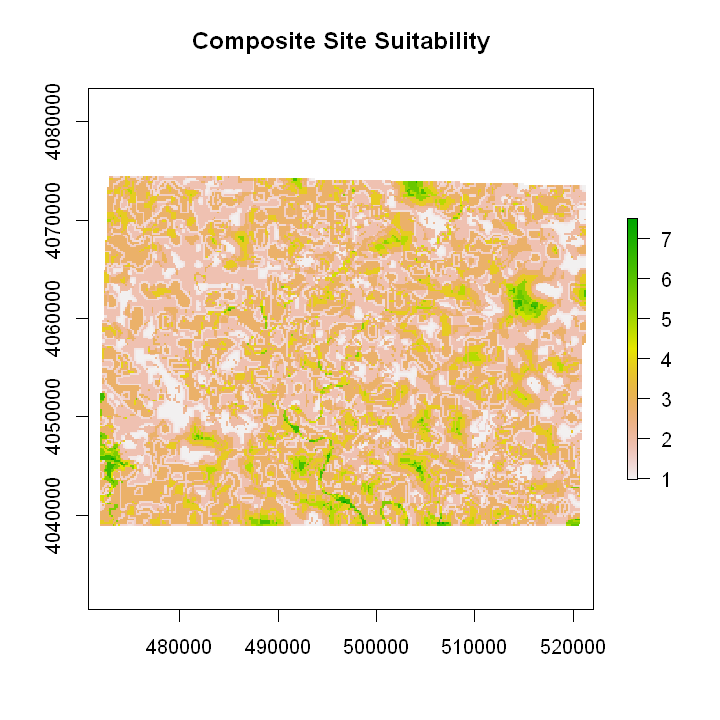

In [35]:
plot(CompositeSuitability, topo.colors, main = "Composite Site Suitability")